# Homework 3: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

The sample code for skip-gram model is given. Your job is to incorporate the tokenizer model that you created in HomeWork-1 to tokenize raw text and turn it into word vectors.

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.

As a reminder,

### Don't forget to shut down your instance on Gcloud when you are not using it ###


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout
from keras.models import load_model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras import backend as K
from keras.optimizers import Adam


random.seed(42)

Using TensorFlow backend.


## Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [3]:
#Step 1: read the wikipedia text file
cwd = os.getcwd()
with open("/home/ekapolc/corpora/wiki/thwiki_chk.txt") as f:
    raw_text = [] 
    #The text file is already tokenized BUT...
    #we've replaced all the spaces between words, so you have to use your tokenizer.
    raw_text.extend(re.sub(r"\s+","",f.read()))
    #since the wiki file is very large, we will only use 1/20 of the whole wiki file in this homework
    # if you have enough memeory and want to add more training data, please feel free to edit this code
    # to include more data
    raw_text = raw_text[:len(raw_text)//20]


In [4]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}
char = np.array(CHARS)

In [5]:
def create_n_gram_df(df, n_pad):
    """
    Given an input dataframe, create a feature dataframe of shifted characters
    Input:
    df: timeseries of size (N)
    n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used 
    as features for that character.

    Output:
    dataframe of size (N * n_pad) which each row contains the character, 
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
    """
    n_pad_2 = int((n_pad - 1)/2)
    for i in range(n_pad_2):
        df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
        df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
    return df[n_pad_2: -n_pad_2]


def prepare_wiki_feature(raw_text_input):
    """
    Transform the path to a directory containing processed files 
    into a feature matrix and output array
    """
    # we use padding equals 21 here to consider 10 characters to the left
    # and 10 characters to the right as features for the character in the middle
    n_pad = 21
    n_pad_2 = int((n_pad - 1)/2)
    pad = [{'char': ' ', 'target': True}]
    df_pad = pd.DataFrame(pad * n_pad_2)

    df = []

    df.append(pd.DataFrame(  {'char': raw_text_input}))

    df = pd.concat(df)
    # pad with empty string feature
    df = pd.concat((df_pad, df, df_pad))

    # map characters to numbers, use 'other' if not in the predefined character set.
    df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

    # Use nearby characters as features
    df_with_context = create_n_gram_df(df, n_pad=n_pad)

    char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

    # convert pandas dataframe to numpy array to feed to the model
    x_char = df_with_context[char_row].as_matrix()

    return x_char

#A function for displaying our features in text
def print_features(tfeature,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    print(center + ': ' + word )

## <font color='blue'>Homework Question1:</font>
<font color='blue'>Use your own tokenizer (aka word segmentation model)  to define word boundaries and split the given text file into words.  Capture the screenshot of your code segment that loads the word segmentation model and uses the model to segment the text files. </font>

In [20]:
# TODO#1 
#load your word segmentation model here!

from keras.models import Model
from keras.layers import Input, Conv1D, Embedding, TimeDistributed, Flatten, Dense
from keras.optimizers import Adam

def get_conv1d_nn():
    input1 = Input(shape=(21,))
    x = Embedding(len(CHARS), 32)(input1)
    x = Conv1D(100, 5, strides=1, activation='relu', padding="same")(x)
    x = TimeDistributed(Dense(5))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])
    
    return model

model = get_conv1d_nn()

#load weights here/ or alternatively you can also load your entire model
weight_path_conv1d_nn='/data/model_weight_conv1d_nn.h5'
model.load_weights(weight_path_conv1d_nn)
model._make_predict_function()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 21, 32)            5696      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 21, 100)           16100     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 21, 5)             505       
_________________________________________________________________
flatten_4 (Flatten)          (None, 105)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10600     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total para

In [21]:
x_char= prepare_wiki_feature(raw_text)
#feel free to edit prepare_wiki_feature if your model has different input format
# As a sanity check, we print out the size of the data.
print(' data shape: ', x_char.shape)


 data shape:  (7592023, 21)


In [22]:
def char_to_word(raw_text, y_pred):
    """ add spaces between words in the raw text based on your prediction
    """
    split_text=""
    for char, y in zip(raw_text,y_pred):
        if y == 1:
            split_text+=" "
            split_text+=char
        else:
            split_text+=char
    return split_text.split(" ")

In [23]:
####TOKENIZATION
###THIS MIGHT TAKE ABOUT 10 MINS on feed forward models
y_pred = model.predict(x_char)
prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
y_pred = np.apply_along_axis(prob_to_class,1,y_pred)
del x_char #clear up some memory

In [24]:
tokens= char_to_word(raw_text, y_pred)
#print out first 100 words for sanity check
print(tokens[0:100])

['', 'หน้าหลักวิกิพี', 'เดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิวิกิมี', 'เดียองค์กร', 'ไม่', 'แสวง', 'ผล', 'กำไร', 'ผู้', 'ดำเนินการ', 'อีก', 'หลาย', 'ได้', 'แก่__NOEDITSECTION__ดาราศาสตร์ดาราศาสตร์', 'คือ', 'วิชาวิทยาศาสตร์', 'ที่', 'ศึกษา', 'วัตถุ', 'ท้องฟ้า', '(', 'อาทิดาวฤกษ์', 'ดาว', 'เคราะห์', 'ดาว', 'หาง', 'และ', 'ดาราจักร', ')', 'รวม', 'ทั้ง', 'ปรากฏการณ์', 'ทาง', 'ธรรมชาติ', 'ต่างๆ', 'ที่', 'เกิด', 'ขึ้น', 'จาก', 'นอก', 'ชั้น', 'บรรยากาศ', 'ของ', 'โลก', 'โดย', 'ศึกษา', 'เกี่ยว', 'กับ', 'วิวัฒนาการ', 'ลักษณะ', 'ทาง', 'กาย', 'ภาพ', 'ทาง', 'เคมี', 'ทาง', 'อุตุนิยมวิทยา', 'และ', 'การ', 'เคลื่อน', 'ที่', 'ของ', 'วัตถุ', 'ท้องฟ้า', 'ตลอดจน', 'ถึง', 'การ', 'กำเนิด', 'และ', 'วิวัฒนาการ', 'ของ', 'เอกภพดาราศาสตร์', 'เป็น', 'หนึ่ง', 'ใน', 'สาขา', 'ของ', 'วิทยาศาสตร์', 'ที่', 'เก่าแก่', 'ที่สุด', 'นัก', 'ดาราศาสตร์', 'ใน', 'วัฒนธรรม', 'โบราณ', 'สังเกตการณ์', 'ดวง', 'ดาวบน', 'ท้องฟ้า', 'ใน', 'เวลา', 'กลาง', 'คืน', 'และ', 'วัตถุ', 'ทาง']


In [25]:
print("total word count:", len(tokens))

total word count: 1758942


## Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='blue'>Homework Question 2:</font>
<font color='blue'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='blue'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

In [29]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text):
    # TODO#2:edit or replace this function
    words = [word for word in input_text ]
    word_count = list()
    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    
    #include a token for unknown word
    threshold = len(input_text)//1000000
    num_UNK = 0
    rare_word = set()
    
    index = len(word_count) - 1
    while(word_count[index][1] <= threshold):
        num_UNK += word_count[index][1]
        rare_word.add(word_count[index][0])
        index -= 1 
    
    word_count = word_count[:index+1]
    word_count.append(("UNK",num_UNK))
    word_count = sorted(word_count, key=lambda x: -x[1])
    
    #print out 10 most frequent words
    print(word_count[:10])
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
        if(word not in rare_word):
            data.append(dictionary[word])
        else:
            data.append(dictionary["UNK"])

    return data,dictionary, reverse_dictionary

dataset,dictionary, reverse_dictionary=create_index(tokens)


[('UNK', 71716), ('ที่', 48030), ('ใน', 43686), ('การ', 40235), ('เป็น', 35899), ('และ', 35370), ('ของ', 33745), ('มี', 30377), ('ได้', 25583), ('"', 18011)]


In [30]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [1, 1, 905, 567, 18, 6834, 15036, 26, 5115, 86]
output sample (dictionary): {'เฮซซูอาจ': 25108, 'ลาภ': 14308, 'แมง': 7163, 'เท': 6891, 'ทรัม': 12672, 'ลั่น': 8405, 'สภาเดียว': 5629, 'ปลด': 1036, 'อธิการบดี': 3569, 'muhafazah': 16131}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'UNK', 2: 'ที่', 3: 'ใน', 4: 'การ', 5: 'เป็น', 6: 'และ', 7: 'ของ', 8: 'มี', 9: 'ได้'}


In [31]:
len(dictionary)

27752

# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='blue'>Homework Question 3:</font>
<font color='blue'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



In [32]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
#TO DO#3 check out keras source code and find out  their sampling technique works
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])



[[5115, 26], [5115, 23463], [5115, 13747], [15036, 21296], [6834, 18], [5115, 86], [15036, 26], [86, 7224], [86, 5115], [6834, 15036], [15036, 22982], [6834, 14720], [6834, 17857], [15036, 6834]] [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
แสวง ไม่
แสวง ตุลาฯ
แสวง รูปวงกลม
เดียองค์กร หนังการ
มูลนิธิวิกิมี โดย
แสวง ผล
เดียองค์กร ไม่
ผล สรรเสริญ


# Step 4: create the skip-gram model
## <font color='blue'>Homework Question 4:</font>
 <font color='blue'>Q4:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

In [33]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_9 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 1, 32)         888064      input_8[0][0]                    
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1, 32)         888064      input_9[0][0]                    
___________________________________________________________________________________________

In [35]:
for _ in range(5):
    prev_i=0
    for i in range(len(dataset)//100000):
        data, labels = skipgrams(sequence=dataset[prev_i:i+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss = SkipGram.train_on_batch(x, y)
        
        print(loss,i*100000)


0.693153 0
0.693041 100000
0.692771 200000
0.692131 300000
0.690881 400000
0.688751 500000
0.685477 600000
0.680785 700000
0.674463 800000
0.666317 900000
0.656145 1000000
0.643858 1100000
0.629363 1200000
0.612522 1300000
0.593485 1400000
0.572235 1500000
0.548981 1600000
0.523844 0
0.497131 100000
0.469372 200000
0.44054 300000
0.411683 400000
0.382632 500000
0.354735 600000
0.327625 700000
0.301992 800000
0.27848 900000
0.256995 1000000
0.23794 1100000
0.221265 1200000
0.206859 1300000
0.194428 1400000
0.184456 1500000
0.175791 1600000
0.168674 0
0.162677 100000
0.158439 200000
0.154304 300000
0.151252 400000
0.1488 500000
0.146387 600000
0.144619 700000
0.14239 800000
0.141289 900000
0.1399 1000000
0.138813 1100000
0.138091 1200000
0.136607 1300000
0.135717 1400000
0.135194 1500000
0.134678 1600000
0.133464 0
0.132949 100000
0.132195 200000
0.131485 300000
0.131468 400000
0.130603 500000
0.129985 600000
0.129874 700000
0.129154 800000
0.128697 900000
0.128473 1000000
0.127994 11000

In [36]:
SkipGram.save_weights('/data/my_skipgram32_weights-hw.h5')

In [37]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)

[[-0.03626404 -0.03375838 -0.02141093 ..., -0.03208547  0.00241135
  -0.03613123]
 [ 0.47072595  0.44692108 -0.43080378 ...,  0.45660239  0.45213208
  -0.0505846 ]
 [ 0.3716583   0.40179539 -0.49977648 ...,  0.51705384  0.47181597
  -0.5261898 ]
 ..., 
 [ 0.00897736 -0.04293003  0.02102182 ...,  0.01135989 -0.02149404
   0.04715062]
 [-0.02763419 -0.00248189  0.03159732 ...,  0.04753372 -0.01451727
   0.00819367]
 [-0.01475666  0.02482054  0.00153502 ...,  0.04574862 -0.03199126
  -0.01734079]]


# Step 5: Visualize the embeddings.
## <font color='blue'>Homework Question 5:</font>
<font color='blue'> Visualize the model using TSNE(scikit-kearn) and Tensorboard Projector  include the image(s) of your visualization here and discuss what you observe. </font>

<font color='red'> Don't forget to include the link to your tensorboard  </font>


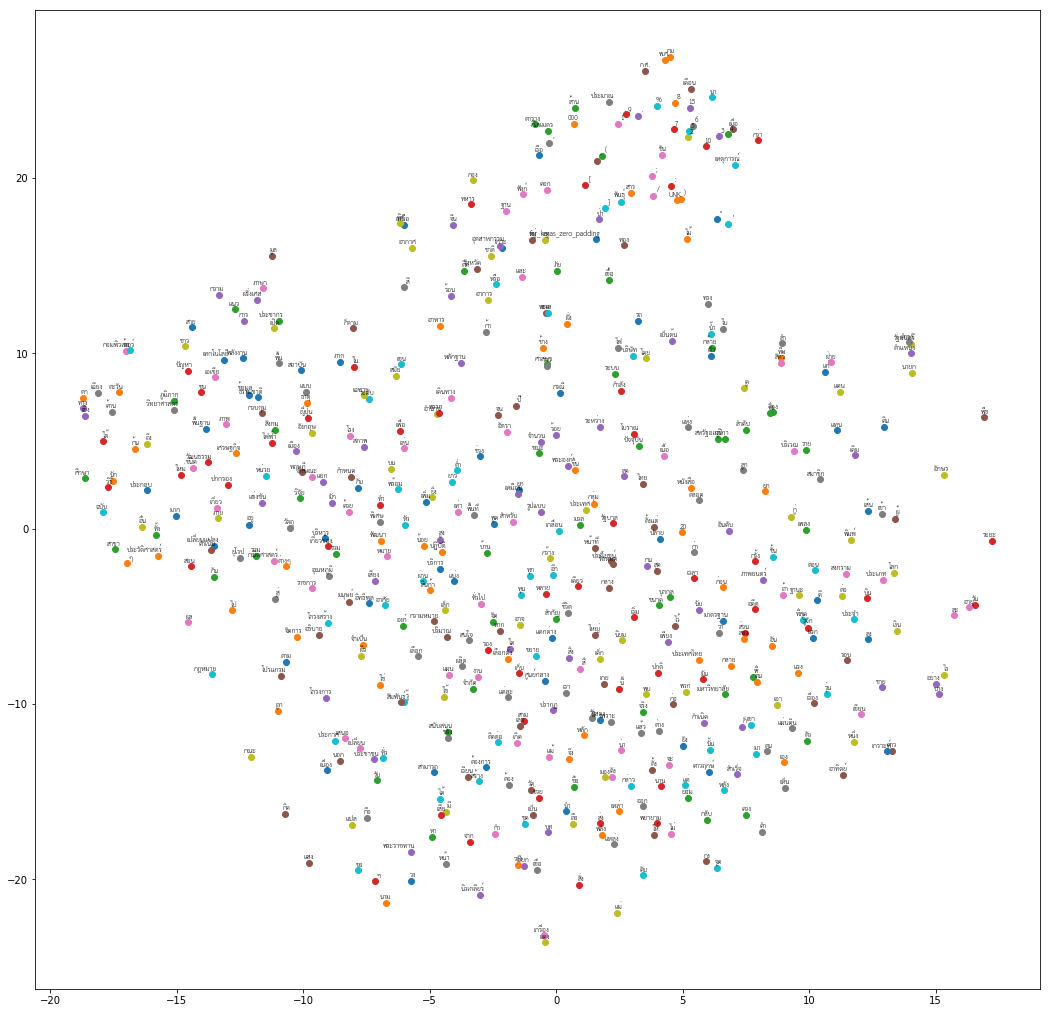

CPU times: user 19.1 s, sys: 4.05 s, total: 23.1 s
Wall time: 23.6 s


In [38]:
%%time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
# Step 5: Visualize the embeddings.
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    fp = mpl.font_manager.FontProperties(family='TH Sarabun New')
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=fp)
    plt.show()
    plt.savefig(filename)





tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# TODO#5:capture the image and tell us what you observe 

In [39]:
#VISUALIZATION ON TENSORBOARD
#you need two files to represent data on tensorboard projector
#1 weights
#2 metadata 
import csv
with open('/data/weights.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerows(final_embeddings[:10000])

with open('/data/metadata.tsv', 'w') as tsvfile:
    for i in range(10000):
        tsvfile.write(reverse_dictionary[i]+"\n")

# Step 6: Evaluation

## <font color='blue'>Homework Question6:</font>
<font color='blue'>
Use the word embeddings from the skip-gram model as pre-trained weights in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [40]:
all_news_filepath = glob.glob('/home/ekapolc/BEST2010/training_set/news/*.txt')
all_novel_filepath = glob.glob('/home/ekapolc/BEST2010/training_set/novel/*.txt')
all_article_filepath = glob.glob('/home/ekapolc/BEST2010/training_set/article/*.txt')
all_encyclopedia_filepath = glob.glob('/home/ekapolc/BEST2010/training_set/encyclopedia/*.txt')

In [41]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)



val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [43]:
#the classification model
#TO DO#6 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary), 32, input_length=max_length,mask_zero=True))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])